## Ocean with periodic boundary

In [2]:
# import a bunch of packages - don't worry about TF warnings
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
#from src.score import *
from collections import OrderedDict

In [3]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# path to shared folder - containing relevant data
root_era5 = '/content/drive/MyDrive/2024METFUT_project_data/ERA5/'

# import the sea surface temperature, sea ice concentration, land-sea-mask
sst    = xr.open_mfdataset(root_era5+'sst_5.625deg/*.nc', combine='by_coords').load()
siconc = xr.open_mfdataset(root_era5+'siconc_5.625deg/*.nc', combine='by_coords').load()
lsm    = xr.open_dataset(root_era5+'lsm_5.625deg.nc').load()

In [5]:
# create daily climatology
sst_clim    = sst.groupby('time.dayofyear').mean()
siconc_clim = siconc.groupby('time.dayofyear').mean()

# fill nan values in datasets - otherwise no learning possible
sst = sst.fillna(sst_clim.sel(dayofyear=sst.time.dt.dayofyear))
siconc = siconc.fillna(siconc_clim.sel(dayofyear=siconc.time.dt.dayofyear))

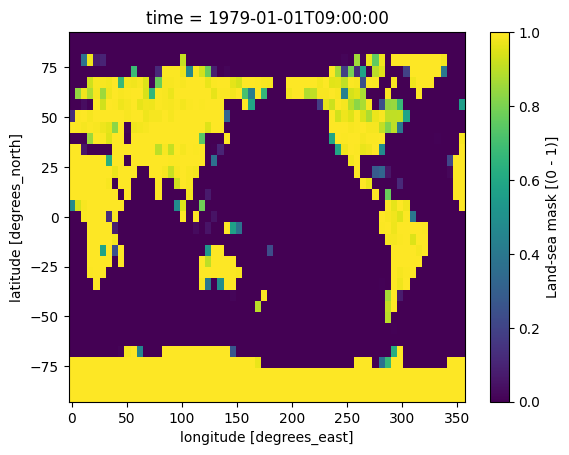

In [6]:
lsm.lsm.isel(time=0).plot()

In [118]:
# create strict land sea mask
slm = xr.where(lsm>0.5,0,1)['lsm'].values[0,:,:]
lsm = xr.where(lsm<0.5,0,1)['lsm'].values[0,:,:]

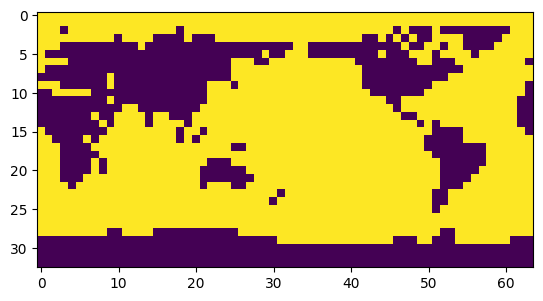

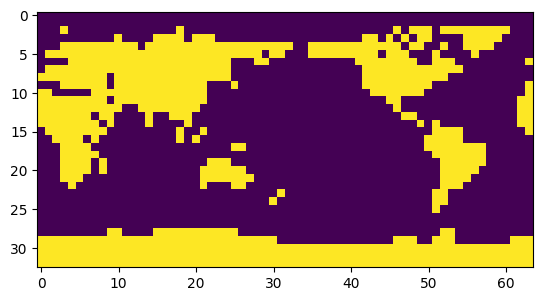

In [120]:
plt.imshow(slm)
plt.show()
plt.imshow(lsm)
plt.show()

## create the training data

In [13]:
data = xr.merge([sst, siconc])

In [23]:
# training dataset selection
train_years = slice('1979', '1982')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('1982', '1983')
# test dataset selection
test_years = slice('1983', '1984')

In [18]:
# pick the forecast lead time
lead_time_steps = 5 # 5 day forecast considering one time step

In [68]:
def get_train_valid_test_dataset(lead_steps, datasets, variables):
  # create lists
  X_train = []
  Y_train = []
  X_valid = []
  Y_valid = []
  X_test  = []
  Y_test  = []
  mean    = np.zeros(len(datasets))
  std     = np.zeros(len(datasets))

  # iterate over index
  for i, d in enumerate(datasets):

    # Split train, valid and test dataset
    train_d = d.sel(time=train_years)
    valid_d = d.sel(time=valid_years)
    test_d  = d.sel(time=test_years)

    # Normalize the data using the mean and standard deviation of the training data
    mean[i] = d.mean()[variables[i]].values
    std[i]  = d.std()[variables[i]].values

    train_d = (train_d - mean[i]) / std[i]
    valid_d = (valid_d - mean[i]) / std[i]
    test_d  = (test_d  - mean[i]) / std[i]

    #mean = mean['sst'].values # extract numerical value from xarray Dataset
    #std = std['sst'].values # extract numerical value from xarray Dataset

    # Create inputs and outputs that are shifted by lead_steps
    X_train.append(getattr(train_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_train.append(getattr(train_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])
    X_valid.append(getattr(valid_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_valid.append(getattr(valid_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])
    X_test.append(getattr(test_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_test.append(getattr(test_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])

  # concatenate training data for multi layer input
  X_train = np.concatenate(X_train, axis = 3)
  Y_train = np.concatenate(Y_train, axis = 3)
  X_valid = np.concatenate(X_valid, axis = 3)
  Y_valid = np.concatenate(Y_valid, axis = 3)
  X_test  = np.concatenate(X_test, axis = 3)
  Y_test  = np.concatenate(Y_test, axis = 3)

  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [69]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, [sst, siconc], ['sst', 'siconc'])
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(1456, 33, 64, 2)
(1456, 33, 64, 2)
(725, 33, 64, 2)
(725, 33, 64, 2)
(726, 33, 64, 2)
(726, 33, 64, 2)


## Periodic CNN Network
Copy multiple classes from weatherBench publication

In [70]:
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

# outside of Class
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
        if dr > 0: x = Dropout(dr)(x)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

In [74]:
# set up test model
test_model = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (33, 64, 2))
test_model.compile(keras.optimizers.Adam(1e-4), 'mse')
test_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33, 64, 2)]       0         
                                                                 
 periodic_conv2d_10 (Period  (None, 33, 64, 64)        3264      
 icConv2D)                                                       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 33, 64, 64)        0         
                                                                 
 periodic_conv2d_11 (Period  (None, 33, 64, 64)        102464    
 icConv2D)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 33, 64, 64)        0         
                                                                 
 periodic_conv2d_12 (Period  (None, 33, 64, 64)        1024

In [76]:
# try to feed training data
test_model.fit(X_train, Y_train, batch_size= 128, epochs=1)

12/12 [==============================] - 168s 14s/step - loss: 0.5675


In [86]:
# Convert predictions backto xarray
#pred_test = X_test[:, :, :, :].copy()
pred_test = test_model.predict(X_test[0:2,:,:,:])#.squeeze()   # To remove channel dimension which is 1

1/1 [==============================] - 0s 295ms/step


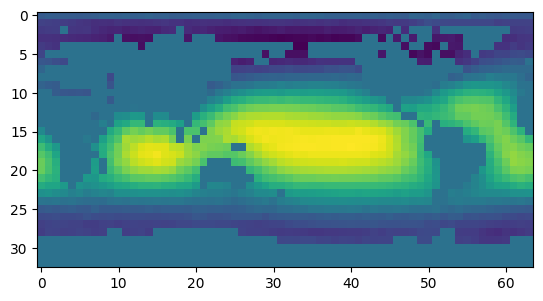

In [128]:
plt.imshow(pred_test[1,:,:,0]*slm)

## create personal loss function

In [152]:
def lsm_loss(y_true, y_pred, lsm=slm):
  #print(y_true.shape)
  lsm = K.constant(np.stack([lsm,lsm],axis=2))
  y_true = y_true * lsm
  y_pred = y_pred * lsm

  return K.sqrt(K.mean(K.square(y_true-y_pred)))

In [137]:
lsm_loss(pred_test[0,:,:,:], pred_test[0,:,:,:]+1)

0.8106769

In [150]:
# another test model
test_model = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (33, 64, 2))
test_model.compile(keras.optimizers.Adam(1e-4), loss=lsm_loss)
test_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 33, 64, 2)]       0         
                                                                 
 periodic_conv2d_40 (Period  (None, 33, 64, 64)        3264      
 icConv2D)                                                       
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 33, 64, 64)        0         
                                                                 
 periodic_conv2d_41 (Period  (None, 33, 64, 64)        102464    
 icConv2D)                                                       
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 33, 64, 64)        0         
                                                                 
 periodic_conv2d_42 (Period  (None, 33, 64, 64)        1024

In [151]:
# try to feed training data
test_model.fit(X_train, Y_train, batch_size= 128, epochs=1)

(None, 33, 64, 2)
(None, 33, 64, 2)
12/12 [==============================] - 166s 14s/step - loss: 0.6578
